### Results 

This notebook reproduces the analyses reported in the paper "Visual cues that predict intuitive risk perception in the case of HIV". 

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.6)
from sklearn import datasets
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score #KFold
#from sklearn.cross_validation import KFold  #using old interface here
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import linear_model

### Relationships between individual cues and perceptions of HIV risk

First, data are read in and a correlation between all cues, and particularly between each cue and the criterion variable "HIV risk" is computed, storing the results in a dataframe. Moreover, we compute basic descriptives for each cue, i.e. the mean (on a 1-7 scale) and standard deviation of ratings across the 240 images.

In [2]:
full_dataset = pd.read_csv('../data/FullSet_240.txt', delimiter='\t')
risk_correlation_dataset = full_dataset.drop([   'BildNr','No','Sex',
               'Trust','Health','Attractiveness',
                           ' CUE3_Appearance3_Unshaved (vs. shaved)_Abstract_0',
                           ' CUE34_Face17_Strong (vs. no) growth of beard_Abstract_0',
                           ' CUE53_Mouth2_Yellow (vs. white) teeth_Abstract_0',
                           ' CUE62_Set8_Dark (vs. well-lit) background_Abstract_0',
                           ' CUE35_GenImp1_Self confident (vs. not)_Abstract_2',
                           ' CUE36_GenImp2_Cautious (vs. risk-seeking)_Abstract_2',
                           ' CUE37_GenImp3_Uneducated (vs. educated)_Abstract_2',
                           ' CUE38_GenImp4_Southern (vs. nordic) type_Abstract_1',
                           ' CUE39_GenImp5_Sporty (vs. unsporty)_Abstract_2',
                           ' CUE40_GenImp6_Scruffy (vs. kempt)_Abstract_2',
                           ' CUE41_GenImp7_Likeable (vs. unsympathetic)_Abstract_2',
                           ' CUE42_GenImp8_Attractive (vs. unattractive)_Abstract_2',
                           ' CUE43_GenImp9_Irresponsible (vs. responsible)_Abstract_2',
                           ' CUE44_GenImp10_Homosexual (vs. heterosexual)_Abstract_2',
                           ' CUE45_GenImp11_Popular (vs. unpopular)_Abstract_2',
                           ' CUE46_GenImp12_Selfish (vs. unselfish)_Abstract_2',
                           ' CUE47_GenImp13_Ill-looking (vs. healthy-looking)_Abstract_2'], axis=1)

# Computing correlations
risk_cue_correlations = risk_correlation_dataset.corr()

# Setting up a dataframe to store the risk-cue-correlations (just a column in the results matrix)
results_table = pd.DataFrame(np.round(risk_cue_correlations.Risk[1:].values, 2) , columns = ['risk_cue_correlations'])

# giving the results table the proper cue names/labels
results_table.index = risk_cue_correlations.index[1:,]

# computing cue means and sds, and putting them into the results_table
results_table['Cue Means'] = np.round(risk_correlation_dataset.describe().loc['mean'][1:].values, 2)
results_table['Cue Stds'] = np.round(risk_correlation_dataset.describe().loc['std'][1:].values,2)
results_table.head()

,risk_cue_correlations,Cue Means,Cue Stds
CUE1_Appearance1_Ungroomed (vs. groomed) appearance_Abstract_2,0.18,3.22,1.04
CUE2_Appearance2_Lot of (vs. no) body adornment_Abstract_0,0.43,2.96,1.11
CUE4_Appearance4_Worn out (vs. intact) clothes_Abstract_1,0.07,2.45,0.81
CUE5_Appearance5_Provocative (vs. reserved) clothes_Abstract_1,0.23,4.09,1.23
CUE6_Appearance6_Unconventional (vs. conventional) appearance_Abstract_1,0.54,3.49,0.74


In [3]:
#results_table.to_csv('../data/table1.csv')

In [4]:
# Uncomment to visually inspect relationships between cues
#df = risk_correlation_dataset.iloc[:, 2:10]
#df.columns = np.arange(2,10,1)
#sns.pairplot(df, kind='reg');

### Predicting HIV risk impressions from visual cues
#### Set up dataset for regression modeling 

After assessing correlations between each cue and HIV risk, the next step is setting up a predictive model to forecast HIV risk from the combination of cues. We begin by creating a dataset (X) and the outcome variable (y - i.e. HIV risk).

In [5]:
# defining datamatrix and outcome vector
X = risk_correlation_dataset
y = X['Risk']
X = X.drop([ 'Risk'], axis=1)
X.head()

,CUE1_Appearance1_Ungroomed (vs. groomed) appearance_Abstract_2,CUE2_Appearance2_Lot of (vs. no) body adornment_Abstract_0,CUE4_Appearance4_Worn out (vs. intact) clothes_Abstract_1,CUE5_Appearance5_Provocative (vs. reserved) clothes_Abstract_1,CUE6_Appearance6_Unconventional (vs. conventional) appearance_Abstract_1,CUE7_Appearance7_Fashionable (vs. unfashionable) appearance_Abstract_1,CUE8_Appearance8_Dark (vs. bright) clothes_Abstract_0,CUE9_Appearance9_Clean (vs. dirty) clothes_Abstract_1,CUE10_Body1_Tense (vs. relaxed) posture_Abstract_1,CUE11_Body2_Musculous (vs. not musculous) stature_Abstract_1,...,CUE64_Skin1_Unhealthy (vs. healthy) skin_Abstract_1,CUE65_Skin2_Pale (vs. tanned) skin_Abstract_0,CUE66_Skin3_Pimply (vs. pimple-free) skin_Abstract_0,CUE67_Skin4_Many (vs. few) skin folds_Abstract_0,CUE68_Skin5_Spotty (vs. spot-free) skin_Abstract_0,CUE69_Skin6_Greasy (vs. dry) skin_Abstract_0,CUE70_Skin7_Lots of (vs. no) skin visible_Abstract_0,CUE71_View1_Coquettish (vs. no coquettish) gaze_Abstract_1,CUE72_View2_Averted (vs. front-facing) gaze_Abstract_0,CUE73_View3_Tired (vs. alert) gaze_Abstract_1
0,4.500,4.125,2.625,2.0000,2.500,3.250,5.5000,3.500,3.000,4.125,...,4.375,3.250,3.750,2.500,2.875,5.625,6.125,2.0000,1.000,3.000
1,2.750,2.125,2.125,3.6250,3.125,4.250,2.1429,5.375,3.625,4.125,...,2.750,3.250,3.125,1.500,1.750,4.000,5.250,5.1250,1.250,4.750
2,4.625,4.625,3.250,2.1429,4.000,4.125,5.7143,3.000,4.625,5.625,...,3.000,6.000,2.375,1.625,1.500,3.250,6.625,2.5000,1.625,4.375
3,3.625,5.125,2.375,3.6250,3.000,4.625,2.7500,5.000,4.625,5.125,...,3.500,4.875,3.375,1.250,2.250,5.000,5.000,4.5000,1.750,4.875
4,2.375,3.250,1.625,5.1250,4.500,5.375,5.7500,5.250,4.250,4.625,...,2.375,4.750,2.250,2.000,2.625,4.250,3.125,4.5714,1.625,2.125


#### Set up Lasso, cross-validate, plot

This is the core analysis that sets up a lasso-regression model and estimates it against the data in a 10-fold cross-validation. Results are then plotted and metrics are assessed.

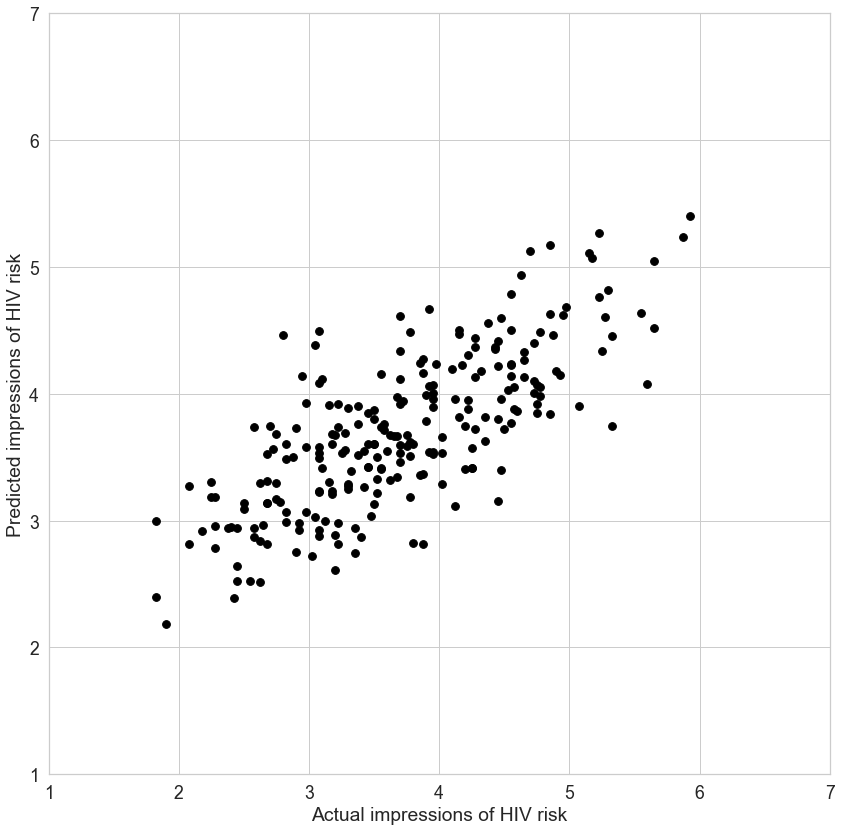

Correlation measured2predicted: 0.75
Mean R2: 0.56
Standard error of the estimate: 0.57


In [6]:
# Defining the LassoEstimator
lasso = linear_model.LassoCV()

# predict the data
predicted = cross_val_predict(lasso, X, y, cv=10)

# plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (14, 14))
ax.scatter(y, predicted, color = 'black', s = 60)
ax.set_xlabel('Actual impressions of HIV risk')
ax.set_ylabel('Predicted impressions of HIV risk')
ax.set_xlim((1,7))
ax.set_ylim((1,7))
#ax.set_title('Result of Lasso Regression')
#sns.despine()
fig.savefig('../data/figure2.tif')
plt.show()

# give correlation between measured and predicted results
corr_m2p = np.corrcoef(y, predicted)[0,1]
corr_m2p = np.round(corr_m2p, 2)
print( 'Correlation measured2predicted: '  + str( corr_m2p ) )

# compute x-val score r2 and mean thereof
scores = cross_val_score(lasso, X, y, cv=10, scoring = 'r2')
m_r2 = np.mean(scores)
m_r2 = np.round(m_r2, 2)
print('Mean R2: ' + str( m_r2 ) )

# computing the standard error of the estimate 
se = np.sqrt(np.sum((y-predicted)**2)/len(y))
se = np.round(se, 2)
print('Standard error of the estimate: ' + str( se ) )


# get lasso coefficients
lasso_model = lasso.fit(X, y)
len(lasso_model.coef_)

results_table['Lasso Coefficients'] = np.round(lasso_model.coef_, 2)
#results_table
results_table.to_csv('../data/results_table.csv')

#### Inspecting the Lasso coefficients

In addition to know that the model predicts HIV risk quite well, we want to know which cues are particularly important. We do so by sorting the cue-coefficients

In [7]:
sorted = results_table.sort_values('Lasso Coefficients', ascending=False)
print('Top 5')
print(sorted['Lasso Coefficients'][:5])
print('-----')
print('Bottom 5')
sorted['Lasso Coefficients'][-5:]

Top 5
 CUE6_Appearance6_Unconventional (vs. conventional) appearance_Abstract_1    0.31
 CUE23_Face6_Worn (vs. fresh) face_Abstract_1                                0.20
 CUE2_Appearance2_Lot of (vs. no) body adornment_Abstract_0                  0.14
 CUE71_View1_Coquettish (vs. no coquettish) gaze_Abstract_1                  0.12
 CUE16_Eyes2_Reddened (vs. non-reddened) eyes_Abstract_0                     0.12
Name: Lasso Coefficients, dtype: float64
-----
Bottom 5


 CUE32_Face15_Friendly (vs. grumpy) expression_Abstract_1       -0.03
 CUE11_Body2_Musculous (vs. not musculous) stature_Abstract_1   -0.04
 CUE29_Face12_Average (vs. unusual) face_Abstract_1             -0.08
 CUE14_Body5_Tall (vs.low) height_Abstract_0                    -0.09
 CUE12_Body3_Overweight (vs. underweight)_Abstract_0            -0.11
Name: Lasso Coefficients, dtype: float64

In [8]:
sorted = results_table.sort_values('Lasso Coefficients', ascending=False)
print('Top 5')
print(sorted['Lasso Coefficients'][:5])
print('-----')
print('Bottom 5')
sorted['Lasso Coefficients'][-5:]

Top 5
 CUE6_Appearance6_Unconventional (vs. conventional) appearance_Abstract_1    0.31
 CUE23_Face6_Worn (vs. fresh) face_Abstract_1                                0.20
 CUE2_Appearance2_Lot of (vs. no) body adornment_Abstract_0                  0.14
 CUE71_View1_Coquettish (vs. no coquettish) gaze_Abstract_1                  0.12
 CUE16_Eyes2_Reddened (vs. non-reddened) eyes_Abstract_0                     0.12
Name: Lasso Coefficients, dtype: float64
-----
Bottom 5


 CUE32_Face15_Friendly (vs. grumpy) expression_Abstract_1       -0.03
 CUE11_Body2_Musculous (vs. not musculous) stature_Abstract_1   -0.04
 CUE29_Face12_Average (vs. unusual) face_Abstract_1             -0.08
 CUE14_Body5_Tall (vs.low) height_Abstract_0                    -0.09
 CUE12_Body3_Overweight (vs. underweight)_Abstract_0            -0.11
Name: Lasso Coefficients, dtype: float64

#### Setting up a conventional regression model
The above results rely on Lasso-regression. The classical approach would be a standard linear regression. Due to multicolinearity, this model is not advisable, but in this case does not markedly change the results.

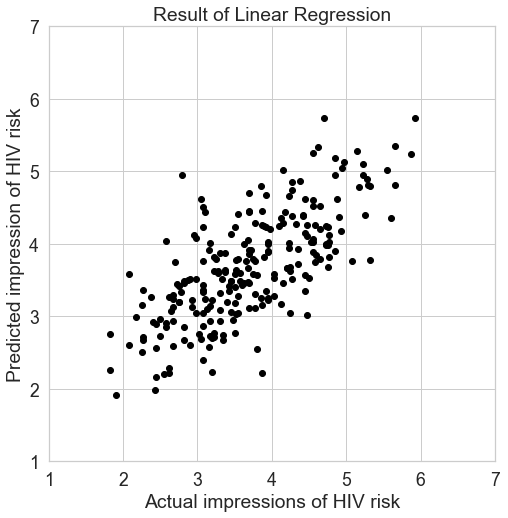

Correlation measured2predicted: 0.71
Mean R2: 0.48
Standard error of the estimate: 0.62


In [9]:
lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(y, predicted, color = 'black')
ax.set_xlabel('Actual impressions of HIV risk')
ax.set_ylabel('Predicted impression of HIV risk')
ax.set_xlim((1,7))
ax.set_ylim((1,7))
ax.set_title('Result of Linear Regression')
plt.show()

# give correlation between measured and predicted results
corr_m2p = np.corrcoef(y, predicted)[0,1]
corr_m2p = np.round(corr_m2p, 2)
print( 'Correlation measured2predicted: '  + str( corr_m2p ) )

# compute x-val score r2 and mean thereof
scores = cross_val_score(lr, X, y, cv=10, scoring = 'r2')
m_r2 = np.mean(scores)
m_r2 = np.round(m_r2, 2)
print('Mean R2: ' + str( m_r2 ) )

# computing the standard error of the estimate 
se = np.sqrt(np.sum((y-predicted)**2)/len(y))
se = np.round(se, 2)
print('Standard error of the estimate: ' + str( se ) )

# get lasso coefficients
lr_model = lr.fit(X, y)
len(lr_model.coef_)

results_table['LR Coefficients'] = np.round(lr_model.coef_, 2)
#results_table

#### Reducing the cues to concrete  ones and running same LASSO model

Inspecting the models above reveals that some of the most informative cues are themselves abstractions (e.g. "unconventional appearance"). This is expected since HIV risk is likely a "compound impression" and not neatly tied to e.g. the brightness of the image. However, to examine how the results change if we confine the data to concrete (clearly observable) cues, we run the same procedures using a reduced dataset.

In [10]:
n_cues = len(X.columns.values)
abstraction_selector = np.ones(n_cues)
for run in range(n_cues):
    if (int(X.columns.values[run][-1]) > 0) :
            abstraction_selector[run] = 0

X_concrete = X.iloc[:, np.where(abstraction_selector > 0)[0]  ]

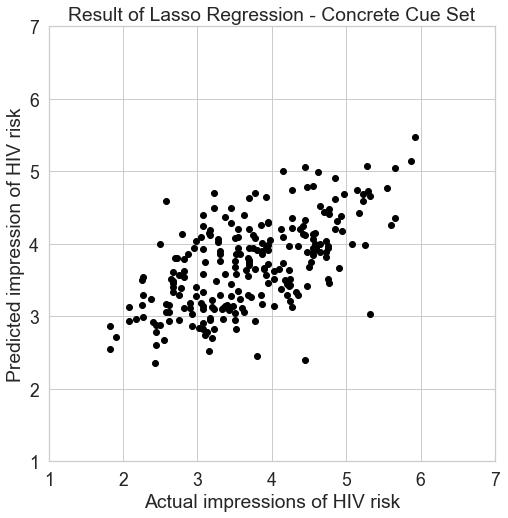

Correlation measured2predicted: 0.61
Mean R2: 0.35
Standard error of the estimate: 0.69


In [11]:
# predict the data
predicted = cross_val_predict(lasso, X_concrete, y, cv=10)

# plot
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(y, predicted, color = 'black')
ax.set_xlabel('Actual impressions of HIV risk')
ax.set_ylabel('Predicted impression of HIV risk')
ax.set_xlim((1,7))
ax.set_ylim((1,7))
ax.set_title('Result of Lasso Regression - Concrete Cue Set')
plt.show()

# give correlation between measured and predicted results
corr_m2p = np.corrcoef(y, predicted)[0,1]
corr_m2p = np.round(corr_m2p, 2)
print( 'Correlation measured2predicted: '  + str( corr_m2p ) )

# compute x-val score r2 and mean thereof
scores = cross_val_score(lasso, X_concrete, y, cv=10, scoring = 'r2')
m_r2 = np.mean(scores)
m_r2 = np.round(m_r2, 2)
print('Mean R2: ' + str( m_r2 ) )

# computing the standard error of the estimate 
se = np.sqrt(np.sum((y-predicted)**2)/len(y))
se = np.round(se, 2)
print('Standard error of the estimate: ' + str( se ) )


# get lasso coefficients
lasso_model_reduced = lasso.fit(X_concrete, y)
len(lasso_model_reduced.coef_)

results_table_reduced = pd.DataFrame(  index= X_concrete.columns.values)

results_table_reduced['Lasso Coefficients ConcreteOnly'] = np.round(lasso_model_reduced.coef_, 2)
#results_table

In [12]:
sorted = results_table_reduced.sort_values('Lasso Coefficients ConcreteOnly', ascending=False)
print('Top 5')
print(sorted['Lasso Coefficients ConcreteOnly'][:5])
print('-----')
print('Bottom 5')
sorted['Lasso Coefficients ConcreteOnly'][-5:]

Top 5
 CUE57_Set3_Alcohol (vs. no alcohol) visible_Abstract_0        0.29
 CUE16_Eyes2_Reddened (vs. non-reddened) eyes_Abstract_0       0.26
 CUE2_Appearance2_Lot of (vs. no) body adornment_Abstract_0    0.25
 CUE68_Skin5_Spotty (vs. spot-free) skin_Abstract_0            0.17
 CUE54_Mouth3_Full (vs. narrow) lips_Abstract_0                0.15
Name: Lasso Coefficients ConcreteOnly, dtype: float64
-----
Bottom 5


 CUE14_Body5_Tall (vs.low) height_Abstract_0                        -0.09
 CUE59_Set5_Picture taken in nature (vs. civilization)_Abstract_0   -0.10
 CUE66_Skin3_Pimply (vs. pimple-free) skin_Abstract_0               -0.12
 CUE12_Body3_Overweight (vs. underweight)_Abstract_0                -0.22
 CUE61_Set7_Food (vs. no food) visible_Abstract_0                   -0.45
Name: Lasso Coefficients ConcreteOnly, dtype: float64

### How does HIV risk perception relate to general person impressions?

In [13]:
full_dataset
impression_dataset = full_dataset[['Risk', 
                                   ' CUE35_GenImp1_Self confident (vs. not)_Abstract_2',
                                   ' CUE36_GenImp2_Cautious (vs. risk-seeking)_Abstract_2',
                                   ' CUE37_GenImp3_Uneducated (vs. educated)_Abstract_2',
                                   ' CUE38_GenImp4_Southern (vs. nordic) type_Abstract_1',
                                   ' CUE39_GenImp5_Sporty (vs. unsporty)_Abstract_2',
                                   ' CUE40_GenImp6_Scruffy (vs. kempt)_Abstract_2',
                                   ' CUE41_GenImp7_Likeable (vs. unsympathetic)_Abstract_2',
                                   ' CUE42_GenImp8_Attractive (vs. unattractive)_Abstract_2',
                                   ' CUE43_GenImp9_Irresponsible (vs. responsible)_Abstract_2',
                                   ' CUE44_GenImp10_Homosexual (vs. heterosexual)_Abstract_2',
                                   ' CUE45_GenImp11_Popular (vs. unpopular)_Abstract_2',
                                   ' CUE46_GenImp12_Selfish (vs. unselfish)_Abstract_2',
                                   ' CUE47_GenImp13_Ill-looking (vs. healthy-looking)_Abstract_2',]
                                 ]

risk_impressions_correlations = impression_dataset.corr()

# Setting up a dataframe to store the risk-cue-correlations (just a column in the results matrix)
impression_results_table = pd.DataFrame(np.round(risk_impressions_correlations.Risk[1:].values, 2) , columns = ['risk_impressions_correlations'])



# giving the results table the proper cue names/labels
impression_results_table.index = risk_impressions_correlations.index[1:,]

# computing cue means and sds, and putting them into the results_table
impression_results_table['Mean Rating'] = np.round(impression_dataset.describe().loc['mean'][1:].values, 2)
impression_results_table['Std'] = np.round(impression_dataset.describe().loc['std'][1:].values,2)
impression_results_table
impression_results_table.to_csv('../data/impression_results_table.csv')

### The relationship between impressions of HIV risk to perceptions of trust, health,  and attractiveness.

#### Correlations between variables
First, we can just examine the correlations between HIV risk and other dimensions of social impressions.

In [14]:
variables = [ 'Risk',
              'Trust',
              'Health',
              'Attractiveness']

full_dataset[variables].corr()   

,Risk,Trust,Health,Attractiveness
Risk,1.000000,-0.804919,-0.442681,0.030642
Trust,-0.804919,1.000000,0.603763,0.295373
Health,-0.442681,0.603763,1.000000,0.683950
Attractiveness,0.030642,0.295373,0.683950,1.000000


In [15]:
for curr_var in variables:
    var = full_dataset[curr_var]
    print(curr_var)
    print(min(var) )
    print(max(var) )
    print(np.mean(var) )
    print(np.std(var) )
    print('----')

Risk
1.825
5.925
3.702916666666667
0.8595098126580962
----
Trust
1.625
6.25
4.097708333333333
0.8220369506682098
----
Health
2.125
6.325
4.4007291666666655
0.8297633884523782
----
Attractiveness
1.35
6.45
3.6617708333333336
1.1567507877596794
----


#### Create analogous models for Trust, Health, Attractiveness as for HIV risk

Next, just as we created models for HIV risk above, we can train analogous models for different criterion variables.

In [16]:
# use the same cue-dataset to train a model for the other variables
X = risk_correlation_dataset.drop([ 'Risk'], axis=1) 

for curr_var in variables:
    #print(curr_var)
    y = full_dataset[curr_var]
    
    scores = cross_val_score(lasso, X, y, cv = 5, scoring = 'r2')
    m_r2 = np.mean(scores)
    m_r2 = np.round(m_r2, 2)
    print(curr_var +  '-Mean R2: ' + str( m_r2 ) )

    predicted = cross_val_predict(lasso, X, y, cv = 10)

    # give correlation between measured and predicted results
    corr_m2p = np.corrcoef(y, predicted)[0,1]
    corr_m2p = np.round(corr_m2p, 2)
    print( curr_var + ' - Correlation measured2predicted: '  + str( corr_m2p ) )

Risk-Mean R2: 0.56
Risk - Correlation measured2predicted: 0.75
Trust-Mean R2: 0.5
Trust - Correlation measured2predicted: 0.74
Health-Mean R2: 0.65
Health - Correlation measured2predicted: 0.83
Attractiveness-Mean R2: 0.76
Attractiveness - Correlation measured2predicted: 0.89


#### Use models fitted on other Trust/Health/Attractiveness to predict HIV risk in new data

Finally, we can train models to predict trust (or health, or attractiveness), and test how well these models would predict HIV risk. Of note, the behavior of these models can be guessed based on the relationships between these variables in the correlation table above. However, it could in principle be that there is a relationship between the variables (e.g. Risk and Trust), but that this reltionship arises from an entirely different cue-utilization process. In classical lens-model style analyses, this would be revealed by so-called vector-correlations, i.e. correlations between the cue-Risk correlation vector and the cue-Trust correlation vector. Our predictive modeling approach is really just another way to look at this phenomenon, i.e. whether same or different cues may drive the judgments. I would argue, though, that it has the advantage of being cross-validated.

In [17]:
len(X)

240

Trust
0.748345738423615
-0.6356267797211379


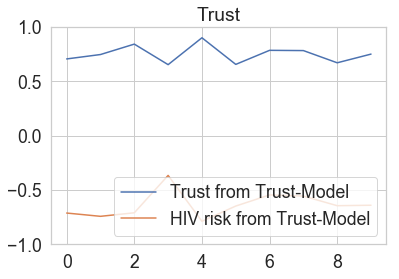

Health
0.8347875733038526
-0.28646157582778853


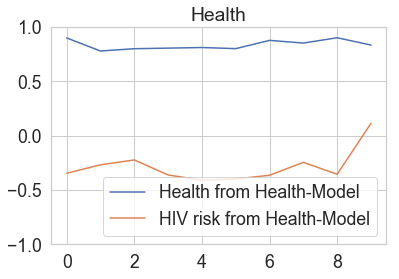

Attractiveness
0.9067268943680515
0.10042548785040598


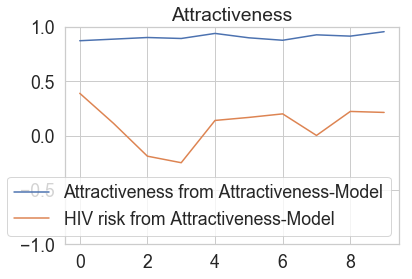

In [18]:
X = risk_correlation_dataset.drop(['Risk'], axis=1) 
X = full_dataset[variables].join(X)

for curr_var in variables[1:]:
    print(curr_var)
    
    res_var_from_var = []
    res_risk_from_var = []

    fold = KFold( 10, shuffle = True)
    # Iterating the KFold object returns tuples of
    # randomly shuffled training and testing indices, 
    # which are then used to select relevant data and labels/outcomes
    for train, test in fold.split(X):   #K = 5
    
        X_train = X.iloc[train]
        X_test = X.iloc[test]

        y_train = X_train[curr_var]
        y_test_var = X_test[curr_var]
        y_test_risk = X_test['Risk']

        X_train = X_train.drop(variables, axis=1)
        X_test = X_test.drop(variables, axis=1)

        lasso_model = lasso.fit(X_train, y_train)
        y_var_predicted = lasso_model.predict(X_test)

        res_var_from_var.append(np.corrcoef(y_var_predicted, y_test_var)[0,1])
        res_risk_from_var.append(np.corrcoef(y_var_predicted, y_test_risk)[0,1])

    print(np.mean(res_var_from_var))    
    print(np.mean(res_risk_from_var))
    plt.plot(res_var_from_var)
    plt.plot(res_risk_from_var)
    #plt.plot([x * -1 for x in res_risk_from_var])
    plt.title(curr_var)
    leg1 = curr_var + " from " + curr_var + '-Model'
    leg2 = 'HIV risk from ' + curr_var + '-Model'
    plt.legend( [leg1, 
                 leg2],
              loc = 'lower right')
    plt.ylim(-1,1)
    plt.show()
                   

In [19]:
print("Done!")

Done!
